# Experiments

## **Criteria**

- **Severe Cases**: Identify at least 90% of severe cases.
- **False Alarms**: Minimize the number of false alarms.

## Logistic Regression

We experimented with various hyperparameters for our Logistic Regression model:

- **`max_iter`**: {100 - 1000}.
- **`solver`**: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', and 'saga'}.
- **`penalty`**: {'l1', 'l2', and 'elasticnet'}.

Despite exploring these options, performance changes were minimal, and we decided to use the default settings.

Additionally, we used a `ColumnTransformer` for scaling, which improved convergence in the logistic regression model.

In [1]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['Age', 'RestBP', 'Chol', 'MaxHR', 'Oldpeak']),  
        ('normalizer', Normalizer(), ['Slope', 'Ca'])],
    remainder='passthrough'
)

In [2]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np


m1_performance = []


for i in range(1, 21):
    # Load datasets
    data = pd.read_csv(f'datasets/dataset{i}/input_train.csv')
    output = np.array(pd.read_csv(f'datasets/dataset{i}/output_train.csv')).reshape(-1)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(data, output, test_size=0.2, stratify=output, random_state=i)

    # ColumnTransformer
    X_train = ct.fit_transform(X_train)
    
    # Train Logistic Regression model
    m1 = LogisticRegression(random_state=42).fit(X_train, y_train)

    # ColumnTransformer
    X_val = ct.transform(X_val)
    
    # Predict probabilities on validation set
    y_val_probs = m1.predict_proba(X_val)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_val, y_val_probs)
    
    # Find the threshold for 90% True Positive Rate (Recall)
    threshold = thresholds_roc[(tpr >= 0.9).argmax()]

    # Test the model
    X_test = pd.read_csv(f'datasets/dataset{i}/input_test.csv')
    y_test = np.array(pd.read_csv(f'datasets/dataset{i}/output_test.csv')).reshape(-1)

    # ColumnTransformer
    X_test = ct.transform(X_test)

    # Predict probabilities on test set
    y_test_probs = m1.predict_proba(X_test)[:, 1]
    
    # Use the threshold obtained previously
    y_test_pred = (y_test_probs >= threshold).astype(int)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    m1_performance.append({"TP": cm[1, 1].item(), "FP": cm[0, 1].item()})


In [3]:
m1_severe_cases = [i['TP'] for i in m1_performance]
m1_false_alarms = [i['FP'] for i in m1_performance]

### Random Forest

Hyperparameters for our Random Forest model:

- **`n_estimators`**: {50 - 500}.
- **`max_depth`**: {10, 15, 20, None}.
- **`max_features`**: {"sqrt", "log2", None}.

Despite trying various parameters, performance changes were minimal. We kept default settings except for `n_estimators`, which we set to 300.

**Note**: We did not use a separate validation set because Random Forests provide out-of-bag (OOB) estimates, which serve a similar purpose.

In [4]:
from sklearn.ensemble import RandomForestClassifier


m2_performance = []


for i in range(1, 21):
    # Load datasets
    data = pd.read_csv(f'datasets/dataset{i}/input_train.csv')
    output = np.array(pd.read_csv(f'datasets/dataset{i}/output_train.csv')).reshape(-1)

    # Train Random Forest model with OOB estimation
    m2 = RandomForestClassifier(n_estimators=300, oob_score=True, random_state=42)
    m2.fit(data, output)
    
    # Get OOB decision function (probabilities)
    y_oob_probs = m2.oob_decision_function_[:, 1]
    
    # Compute ROC curve using OOB estimates
    fpr, tpr, thresholds_roc = roc_curve(output, y_oob_probs)
    
    # Find the threshold for 90% True Positive Rate (Recall)
    threshold = thresholds_roc[(tpr >= 0.9).argmax()]
    
    # Test the model
    X_test = pd.read_csv(f'datasets/dataset{i}/input_test.csv')
    y_test = np.array(pd.read_csv(f'datasets/dataset{i}/output_test.csv')).reshape(-1)
    
    # Predict probabilities on test set
    y_test_probs = m2.predict_proba(X_test)[:, 1]
    
    # Use the threshold obtained previously
    y_test_pred = (y_test_probs >= threshold).astype(int)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    m2_performance.append({"TP": cm[1, 1].item(), "FP": cm[0, 1].item()})


In [5]:
m2_severe_cases = [i['TP'] for i in m2_performance]
m2_false_alarms = [i['FP'] for i in m2_performance]

## XGBoost

Hyperparameters for our XGBoost model:

- **`n_estimators`**: {50 - 500}.
- **`max_depth`**: {4, 5, 6, 7, 8, 9, 10, None}.
- **`max_depth`**: {4, 5, 6, 7, 8, 9, 10, None}.
- **`reg_alpha`**: {0.5, 1, 2, 3, 4, 5}.
- **`reg_lambda`**: {0.5, 1, 2, 3, 4, 5}.
- **`eta`**: {0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6}.

Across different parameters, the performance was nearly the same. We kept default settings except for the `eta` changed to 0.5.

In [6]:
from xgboost import XGBClassifier


m3_performance = []


for i in range(1, 21):
    # Load datasets
    data = pd.read_csv(f'datasets/dataset{i}/input_train.csv')
    output = np.array(pd.read_csv(f'datasets/dataset{i}/output_train.csv')).reshape(-1)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(data, output, test_size=0.2, stratify=output, random_state=i)
    
    # Train XGBoost model
    m3 = XGBClassifier(
        random_state=42, 
        objective='binary:logistic',
        eval_metric='auc',
        eta=0.5
    ).fit(X_train, y_train)
    
    # Predict probabilities on validation set
    y_val_probs = m3.predict_proba(X_val)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_val, y_val_probs)
    
    # Find the threshold for 90% True Positive Rate (Recall)
    threshold = thresholds_roc[(tpr >= 0.9).argmax()]

    # Test the model
    X_test = pd.read_csv(f'datasets/dataset{i}/input_test.csv')
    y_test = np.array(pd.read_csv(f'datasets/dataset{i}/output_test.csv')).reshape(-1)

    # Predict probabilities on test set
    y_test_probs = m3.predict_proba(X_test)[:, 1]
    
    # Use the threshold obtained previously
    y_test_pred = (y_test_probs >= threshold).astype(int)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    m3_performance.append({"TP": cm[1, 1].item(), "FP": cm[0, 1].item()})


In [7]:
m3_severe_cases = [i['TP'] for i in m3_performance]
m3_false_alarms = [i['FP'] for i in m3_performance]

# Evaluation

## Box Plot

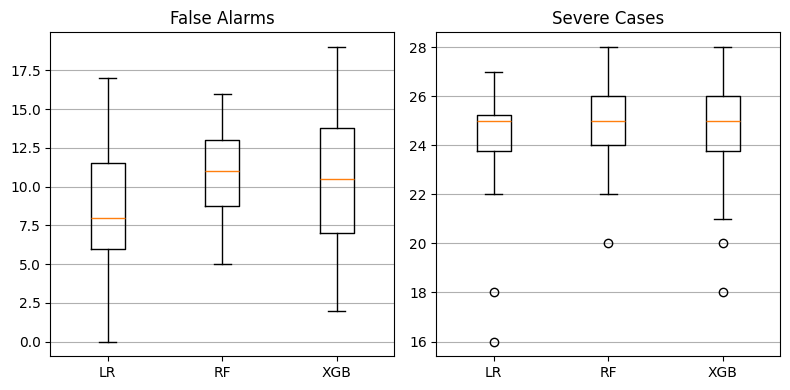

In [10]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# False Alarms boxplots
axs[0].boxplot([m1_false_alarms, m2_false_alarms, m3_false_alarms], tick_labels=['LR', 'RF', 'XGB'])
axs[0].set_title('False Alarms')
axs[0].set_xticks([1, 2, 3])
axs[0].set_xticklabels(['LR', 'RF', 'XGB'])

# Severe Cases boxplots
axs[1].boxplot([m1_severe_cases, m2_severe_cases, m3_severe_cases], tick_labels=['LR', 'RF', 'XGB'])
axs[1].set_title('Severe Cases')
axs[1].set_xticks([1, 2, 3])
axs[1].set_xticklabels(['LR', 'RF', 'XGB'])

# Adding horizontal grid lines
for ax in axs:
    ax.yaxis.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

## Model Comparison: Box Plot Analysis

Looking at the whisker box plot:

- **Severe cases (right side)**: All models show a constant performance.
- **False alarms (left side)**: We can assess which model produces the smallest number of false alarms.

From the analysis, it looks like **Logistic Regression (LR)** and **XGBoost (XGB)** perform better.

Now, it's time see if there's a significant difference in the predictions of these models. This will help us understand if one model truly outperforms the others.


## Bland–Altman Plot

With this technique we can evaluate the agreement between Logistic Regression (LR) and XGBoost (XGB) models.

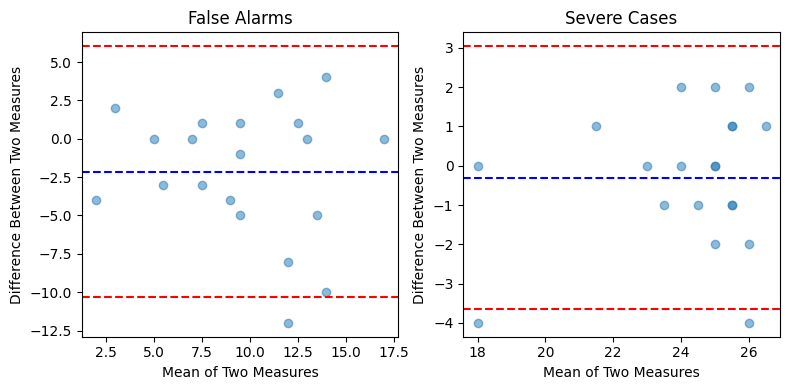

In [11]:
def bland_altman_plot(ax, data1, data2, title='Bland-Altman Plot'):
    data1 = np.array(data1)
    data2 = np.array(data2)
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    md = np.mean(diff)
    sd = np.std(diff)
    
    ax.scatter(mean, diff, alpha=0.5)
    ax.axhline(md, color='blue', linestyle='--', label='Mean Difference (Bias)')
    ax.axhline(md + 1.96*sd, color='red', linestyle='--', label='±1.96 SD')
    ax.axhline(md - 1.96*sd, color='red', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Mean of Two Measures')
    ax.set_ylabel('Difference Between Two Measures')

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

bland_altman_plot(axs[0], m1_false_alarms, m3_false_alarms, title='False Alarms')
bland_altman_plot(axs[1], m1_severe_cases, m3_severe_cases, title='Severe Cases')

plt.tight_layout()
plt.show()

## Bland–Altman Plot Analysis

- **Red Lines (Limits of Agreement)**: These lines represent the range within which most of the differences between the two measurements fall.
- **Blue Line (Bias)**: This line shows the average difference between the two measurements.

We notice that the blue line for false alarms indicates a systematic bias, as it is not close to zero. This means there's a consistent difference between the measurements. However, for severe cases, both models give similar predictions, suggesting they are in agreement and perform similarly.


## Prediction Distribution of the Models

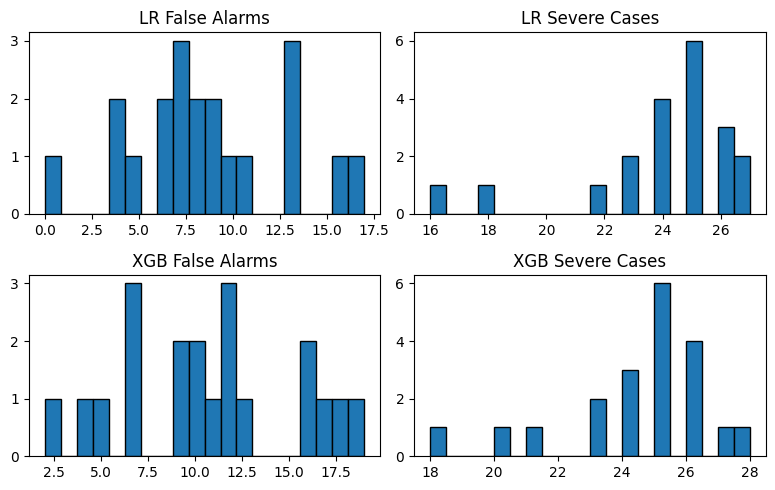

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

axs[0, 0].hist(m1_false_alarms, bins=20, edgecolor='black')
axs[0, 0].set_title('LR False Alarms')
axs[0, 1].hist(m1_severe_cases, bins=20, edgecolor='black')
axs[0, 1].set_title('LR Severe Cases')

axs[1, 0].hist(m3_false_alarms, bins=20, edgecolor='black')
axs[1, 0].set_title('XGB False Alarms')
axs[1, 1].hist(m3_severe_cases, bins=20, edgecolor='black')
axs[1, 1].set_title('XGB Severe Cases')

plt.tight_layout()
plt.show()

## Wilcoxon signed-rank test 

- Since the predictions from both models do not follow a normal distribution, we chose the Wilcoxon Signed-Rank Test. Otherwise, we would use T-test.

In [13]:
from scipy.stats import wilcoxon

# Statistic and p-value
s_severe_cases, p_severe_cases = wilcoxon(m1_severe_cases, m3_severe_cases)
s_false_alarms, p_false_alarms = wilcoxon(m1_false_alarms, m3_false_alarms)

print(f"P-value for severe cases: {p_severe_cases:.3f}")
print(f"P-value for false alarms: {p_false_alarms:.3f}")

P-value for severe cases: 0.601
P-value for false alarms: 0.046


## Performance Analysis

We use a threshold of 0.05 for significance (p-value < 0.05 indicate a significant difference).

### Key Findings

- **False Alarms:** Significant difference between LR and XGB (p-value = 0.046).
- **Severe Cases:** No significant difference (p-value = 0.601).

# Conclusion

Our study suggests that **Logistic Regression (LR)** outperformed the other models in our experiments.